In [1]:
import evaluate
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch

from datasets import Dataset
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score,
    f1_score,
    classification_report,
    precision_score,
    recall_score
)
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    Trainer,
    TrainerCallback
)
from transformers.training_args import TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda


## Read data

In [2]:
data_dir = "../data"
train_data_path = os.path.join(data_dir, 'train_data_llava.json')
test_data_path = os.path.join(data_dir, 'test_data_llava.json')
models_dir = "../models"

def generate_df_from_json(json_path):
  with open(json_path) as f:
    data: dict = json.load(f)
    data_formated= {'caption': [], 'label': []}
    for value in data.values():
      data_formated['caption'].append(value['caption'])
      data_formated['label'].append(value['label'])
  
  df = pd.DataFrame.from_dict(data_formated)
  return df

id2label = {
  0: 'Cultural_Religious',
  1: 'Fauna_Flora',
  2: 'Gastronomy',
  3: 'Nature',
  4: 'Sports',
  5: 'Urban_Rural'
}

label2id = {
  'Cultural_Religious': 0,
  'Fauna_Flora': 1,
  'Gastronomy': 2,
  'Nature': 3,
  'Sports': 4,
  'Urban_Rural': 5
}

train_df = generate_df_from_json(train_data_path)
test_df = generate_df_from_json(test_data_path)
train_df = pd.concat([train_df, test_df], axis=0)
print(train_df)

                                               caption  label
0    The image shows a group of people standing on ...      4
1    The image shows a man wearing a backpack and s...      4
2    The image shows a man standing on a snow-cover...      4
3    The image shows a woman wearing a blue shirt a...      4
4    The image shows a group of people riding bicyc...      4
..                                                 ...    ...
283  The image shows a large, old stone building wi...      0
284  The image shows a large, ornate church with a ...      0
285  The image shows a painting or mural of a man i...      0
286  The image shows a church with a bell tower, wh...      0
287  The image shows a large brick church with a ta...      0

[960 rows x 2 columns]


In [3]:
train_data = Dataset.from_pandas(train_df) #.train_test_split(test_size=0.15, seed=4999)
test_data = Dataset.from_pandas(test_df)
print(train_data)

Dataset({
    features: ['caption', 'label', '__index_level_0__'],
    num_rows: 960
})


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Cultural_Religious'),
  Text(1, 0, 'Fauna_Flora'),
  Text(2, 0, 'Gastronomy'),
  Text(3, 0, 'Nature'),
  Text(4, 0, 'Sports'),
  Text(5, 0, 'Urban_Rural')])

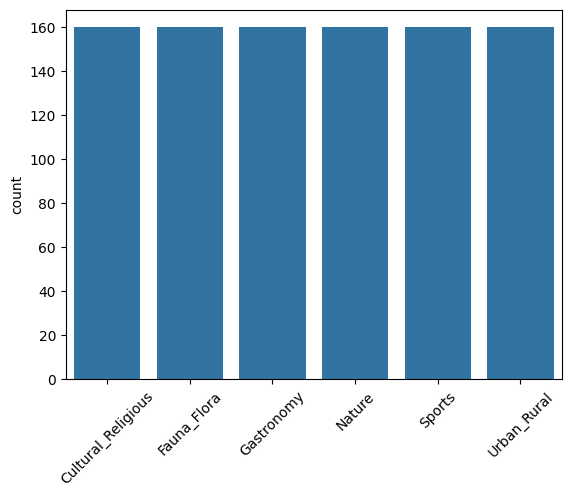

In [4]:
label_count = train_df.groupby(by='label').count()
label_count.columns = ['count']
labels = [id2label[id] for id in label_count.index]
sns.barplot(label_count, x=labels, y='count')
plt.xticks(rotation=45)

## Text classification

In [5]:
model_id = "google-bert/bert-base-uncased"
#model_id = "distilbert/distilbert-base-uncased"
#model_id = "FacebookAI/roberta-base"

### Tokenize data

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

def preprocess_function(examples):
  return tokenizer(examples["caption"], truncation=True)

tokenized_train_data = train_data.map(preprocess_function, batched=True)
tokenized_test_data = test_data.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print(tokenized_train_data)

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Dataset({
    features: ['caption', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 960
})


### Train model

### Without CV

In [6]:
import copy

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=6, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir=f"{models_dir}/roberta",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

class AccuracyHistory(TrainerCallback):
    def __init__(self, trainer):
        super().__init__()
        self.eval_acc = []
        self.train_acc = []
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = copy.deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            if metrics.get('eval_accuracy'):
                self.eval_acc.append(metrics["eval_accuracy"])
            if metrics.get('train_accuracy'):
                self.train_acc.append(metrics['train_accuracy'])
            
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data["train"],
    eval_dataset=tokenized_train_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    #callbacks=[accuracy_history]
)

trainer.add_callback(AccuracyHistory(trainer))

trainer.train()
trainer.save_model(f"{models_dir}/best_roberta_llava")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

{'train_loss': 1.2942354679107666, 'train_accuracy': 0.819614711033275, 'train_runtime': 2.5624, 'train_samples_per_second': 222.838, 'train_steps_per_second': 14.049, 'epoch': 1.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.285083293914795, 'eval_accuracy': 0.8316831683168316, 'eval_runtime': 0.4754, 'eval_samples_per_second': 212.434, 'eval_steps_per_second': 14.723, 'epoch': 1.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_loss': 0.6576547622680664, 'train_accuracy': 0.9019264448336253, 'train_runtime': 2.5753, 'train_samples_per_second': 221.722, 'train_steps_per_second': 13.979, 'epoch': 2.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6746252775192261, 'eval_accuracy': 0.8910891089108911, 'eval_runtime': 0.4791, 'eval_samples_per_second': 210.796, 'eval_steps_per_second': 14.61, 'epoch': 2.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_loss': 0.376678466796875, 'train_accuracy': 0.9439579684763573, 'train_runtime': 2.5897, 'train_samples_per_second': 220.491, 'train_steps_per_second': 13.901, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.42432230710983276, 'eval_accuracy': 0.9207920792079208, 'eval_runtime': 0.4814, 'eval_samples_per_second': 209.824, 'eval_steps_per_second': 14.542, 'epoch': 3.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_loss': 0.27485495805740356, 'train_accuracy': 0.9597197898423818, 'train_runtime': 2.592, 'train_samples_per_second': 220.296, 'train_steps_per_second': 13.889, 'epoch': 4.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.3409046530723572, 'eval_accuracy': 0.9306930693069307, 'eval_runtime': 0.4839, 'eval_samples_per_second': 208.704, 'eval_steps_per_second': 14.465, 'epoch': 4.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_loss': 0.24283617734909058, 'train_accuracy': 0.9649737302977233, 'train_runtime': 2.6162, 'train_samples_per_second': 218.253, 'train_steps_per_second': 13.76, 'epoch': 5.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.3195231854915619, 'eval_accuracy': 0.9306930693069307, 'eval_runtime': 0.491, 'eval_samples_per_second': 205.723, 'eval_steps_per_second': 14.258, 'epoch': 5.0}
{'train_runtime': 58.9569, 'train_samples_per_second': 48.425, 'train_steps_per_second': 3.053, 'train_loss': 0.773082987467448, 'epoch': 5.0}


### With CV

In [7]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import copy
import evaluate

# Load accuracy, precision, and recall metrics
accuracy = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

# Function to compute evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Compute metrics
    accuracy_result = accuracy.compute(predictions=predictions, references=labels)
    precision_result = precision_metric.compute(predictions=predictions, references=labels, average='macro')
    recall_result = recall_metric.compute(predictions=predictions, references=labels, average='macro')
    
    return {
        'accuracy': accuracy_result['accuracy'],
        'precision': precision_result['precision'],
        'recall': recall_result['recall']
    }

# Define the number of folds
n_splits = 5  # K-Fold with 5 splits

# Initialize K-Fold cross-validator
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Tokenized dataset (replace with your actual dataset)
train_dataset = tokenized_train_data
train_labels = train_dataset['label']  # Extract the labels for stratification
train_dataset_size = len(train_dataset)

# Arrays to store results for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []

# Stratified K-Fold loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset, train_labels)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    # Create train and validation sets for this fold
    train_subset = train_dataset.select(train_idx.tolist())
    val_subset = train_dataset.select(val_idx.tolist())

    # Initialize model for the current fold
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id, num_labels=6, id2label=id2label, label2id=label2id
    )

    # Define training arguments for the current fold
    training_args = TrainingArguments(
        output_dir=f"{models_dir}/roberta-fold-{fold + 1}",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
    )

    # Initialize Trainer for this fold
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_subset,
        eval_dataset=val_subset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Add the AccuracyHistory callback
    # trainer.add_callback(AccuracyHistory(trainer))

    # Train the model
    trainer.train()

    # Evaluate the model on the validation subset
    eval_results = trainer.evaluate(eval_dataset=val_subset)
    
    # Store the metrics for this fold
    fold_accuracies.append(eval_results['eval_accuracy'])
    fold_precisions.append(eval_results['eval_precision'])
    fold_recalls.append(eval_results['eval_recall'])
    
    print(f"Fold {fold + 1} accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"Fold {fold + 1} precision: {eval_results['eval_precision']:.4f}")
    print(f"Fold {fold + 1} recall: {eval_results['eval_recall']:.4f}")

# Compute the mean accuracy, precision, and recall across all folds
mean_accuracy = np.mean(fold_accuracies)
mean_precision = np.mean(fold_precisions)
mean_recall = np.mean(fold_recalls)

print(f"\nMean accuracy across {n_splits} folds: {mean_accuracy:.4f}")
print(f"Mean precision across {n_splits} folds: {mean_precision:.4f}")
print(f"Mean recall across {n_splits} folds: {mean_recall:.4f}")


Training fold 1/5...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 1.0120586156845093, 'eval_accuracy': 0.75, 'eval_precision': 0.7120808931954442, 'eval_recall': 0.75, 'eval_runtime': 1.8406, 'eval_samples_per_second': 104.311, 'eval_steps_per_second': 6.519, 'epoch': 1.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.4865931272506714, 'eval_accuracy': 0.8854166666666666, 'eval_precision': 0.8864438937968351, 'eval_recall': 0.8854166666666666, 'eval_runtime': 1.8488, 'eval_samples_per_second': 103.852, 'eval_steps_per_second': 6.491, 'epoch': 2.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.34788838028907776, 'eval_accuracy': 0.9114583333333334, 'eval_precision': 0.9219455585264408, 'eval_recall': 0.9114583333333334, 'eval_runtime': 1.9727, 'eval_samples_per_second': 97.331, 'eval_steps_per_second': 6.083, 'epoch': 3.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.26044249534606934, 'eval_accuracy': 0.9270833333333334, 'eval_precision': 0.9288468401371629, 'eval_recall': 0.9270833333333334, 'eval_runtime': 1.9836, 'eval_samples_per_second': 96.795, 'eval_steps_per_second': 6.05, 'epoch': 4.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.2621481120586395, 'eval_accuracy': 0.921875, 'eval_precision': 0.9244019190255749, 'eval_recall': 0.921875, 'eval_runtime': 1.9644, 'eval_samples_per_second': 97.741, 'eval_steps_per_second': 6.109, 'epoch': 5.0}
{'train_runtime': 127.0967, 'train_samples_per_second': 30.213, 'train_steps_per_second': 1.888, 'train_loss': 0.5666521708170573, 'epoch': 5.0}


  0%|          | 0/12 [00:00<?, ?it/s]

Fold 1 accuracy: 0.9271
Fold 1 precision: 0.9288
Fold 1 recall: 0.9271
Training fold 2/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.9663729667663574, 'eval_accuracy': 0.8541666666666666, 'eval_precision': 0.8742959968766422, 'eval_recall': 0.8541666666666666, 'eval_runtime': 1.5894, 'eval_samples_per_second': 120.803, 'eval_steps_per_second': 7.55, 'epoch': 1.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.4330202639102936, 'eval_accuracy': 0.90625, 'eval_precision': 0.917930742141646, 'eval_recall': 0.90625, 'eval_runtime': 1.5968, 'eval_samples_per_second': 120.244, 'eval_steps_per_second': 7.515, 'epoch': 2.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.24013738334178925, 'eval_accuracy': 0.9375, 'eval_precision': 0.9419161808867691, 'eval_recall': 0.9375, 'eval_runtime': 1.6084, 'eval_samples_per_second': 119.377, 'eval_steps_per_second': 7.461, 'epoch': 3.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.22110317647457123, 'eval_accuracy': 0.9270833333333334, 'eval_precision': 0.9277363159716102, 'eval_recall': 0.9270833333333334, 'eval_runtime': 1.7231, 'eval_samples_per_second': 111.425, 'eval_steps_per_second': 6.964, 'epoch': 4.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.21514730155467987, 'eval_accuracy': 0.9270833333333334, 'eval_precision': 0.9302911467617351, 'eval_recall': 0.9270833333333334, 'eval_runtime': 1.7326, 'eval_samples_per_second': 110.818, 'eval_steps_per_second': 6.926, 'epoch': 5.0}
{'train_runtime': 122.0427, 'train_samples_per_second': 31.464, 'train_steps_per_second': 1.967, 'train_loss': 0.5355585098266602, 'epoch': 5.0}


  0%|          | 0/12 [00:00<?, ?it/s]

Fold 2 accuracy: 0.9271
Fold 2 precision: 0.9303
Fold 2 recall: 0.9271
Training fold 3/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.9852814674377441, 'eval_accuracy': 0.84375, 'eval_precision': 0.8656290674439496, 'eval_recall': 0.84375, 'eval_runtime': 1.6754, 'eval_samples_per_second': 114.597, 'eval_steps_per_second': 7.162, 'epoch': 1.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.40310195088386536, 'eval_accuracy': 0.9427083333333334, 'eval_precision': 0.9430816705959021, 'eval_recall': 0.9427083333333334, 'eval_runtime': 1.6786, 'eval_samples_per_second': 114.382, 'eval_steps_per_second': 7.149, 'epoch': 2.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.22474415600299835, 'eval_accuracy': 0.9427083333333334, 'eval_precision': 0.9442054473304472, 'eval_recall': 0.9427083333333334, 'eval_runtime': 1.6838, 'eval_samples_per_second': 114.028, 'eval_steps_per_second': 7.127, 'epoch': 3.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.16735418140888214, 'eval_accuracy': 0.9635416666666666, 'eval_precision': 0.9641627973281199, 'eval_recall': 0.9635416666666666, 'eval_runtime': 1.6851, 'eval_samples_per_second': 113.942, 'eval_steps_per_second': 7.121, 'epoch': 4.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.15885527431964874, 'eval_accuracy': 0.9635416666666666, 'eval_precision': 0.964608430126694, 'eval_recall': 0.9635416666666666, 'eval_runtime': 1.8136, 'eval_samples_per_second': 105.869, 'eval_steps_per_second': 6.617, 'epoch': 5.0}
{'train_runtime': 118.1673, 'train_samples_per_second': 32.496, 'train_steps_per_second': 2.031, 'train_loss': 0.5098754564921061, 'epoch': 5.0}


  0%|          | 0/12 [00:00<?, ?it/s]

Fold 3 accuracy: 0.9635
Fold 3 precision: 0.9646
Fold 3 recall: 0.9635
Training fold 4/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.9986527562141418, 'eval_accuracy': 0.859375, 'eval_precision': 0.8737872851365015, 'eval_recall': 0.859375, 'eval_runtime': 1.6973, 'eval_samples_per_second': 113.123, 'eval_steps_per_second': 7.07, 'epoch': 1.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.43167003989219666, 'eval_accuracy': 0.9114583333333334, 'eval_precision': 0.9120060566929636, 'eval_recall': 0.9114583333333334, 'eval_runtime': 1.7086, 'eval_samples_per_second': 112.375, 'eval_steps_per_second': 7.023, 'epoch': 2.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.2544163763523102, 'eval_accuracy': 0.9375, 'eval_precision': 0.9370517317386389, 'eval_recall': 0.9375, 'eval_runtime': 1.7072, 'eval_samples_per_second': 112.467, 'eval_steps_per_second': 7.029, 'epoch': 3.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.2033265233039856, 'eval_accuracy': 0.9427083333333334, 'eval_precision': 0.9441102198455139, 'eval_recall': 0.9427083333333334, 'eval_runtime': 1.7042, 'eval_samples_per_second': 112.662, 'eval_steps_per_second': 7.041, 'epoch': 4.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.19693906605243683, 'eval_accuracy': 0.9427083333333334, 'eval_precision': 0.9430673944840012, 'eval_recall': 0.9427083333333334, 'eval_runtime': 1.8314, 'eval_samples_per_second': 104.839, 'eval_steps_per_second': 6.552, 'epoch': 5.0}
{'train_runtime': 118.4623, 'train_samples_per_second': 32.415, 'train_steps_per_second': 2.026, 'train_loss': 0.550137456258138, 'epoch': 5.0}


  0%|          | 0/12 [00:00<?, ?it/s]

Fold 4 accuracy: 0.9427
Fold 4 precision: 0.9431
Fold 4 recall: 0.9427
Training fold 5/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 1.0005451440811157, 'eval_accuracy': 0.84375, 'eval_precision': 0.8445217945217944, 'eval_recall': 0.84375, 'eval_runtime': 1.6954, 'eval_samples_per_second': 113.245, 'eval_steps_per_second': 7.078, 'epoch': 1.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.38629257678985596, 'eval_accuracy': 0.9479166666666666, 'eval_precision': 0.9504292203645651, 'eval_recall': 0.9479166666666666, 'eval_runtime': 1.7004, 'eval_samples_per_second': 112.916, 'eval_steps_per_second': 7.057, 'epoch': 2.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.194372296333313, 'eval_accuracy': 0.9791666666666666, 'eval_precision': 0.9805059523809524, 'eval_recall': 0.9791666666666666, 'eval_runtime': 1.7048, 'eval_samples_per_second': 112.622, 'eval_steps_per_second': 7.039, 'epoch': 3.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.15460869669914246, 'eval_accuracy': 0.96875, 'eval_precision': 0.9713804713804715, 'eval_recall': 0.96875, 'eval_runtime': 1.8492, 'eval_samples_per_second': 103.829, 'eval_steps_per_second': 6.489, 'epoch': 4.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.13887637853622437, 'eval_accuracy': 0.9791666666666666, 'eval_precision': 0.9806637806637807, 'eval_recall': 0.9791666666666666, 'eval_runtime': 1.8372, 'eval_samples_per_second': 104.509, 'eval_steps_per_second': 6.532, 'epoch': 5.0}
{'train_runtime': 121.0376, 'train_samples_per_second': 31.726, 'train_steps_per_second': 1.983, 'train_loss': 0.5347159067789714, 'epoch': 5.0}


  0%|          | 0/12 [00:00<?, ?it/s]

Fold 5 accuracy: 0.9792
Fold 5 precision: 0.9807
Fold 5 recall: 0.9792

Mean accuracy across 5 folds: 0.9479
Mean precision across 5 folds: 0.9495
Mean recall across 5 folds: 0.9479


In [7]:
accuracy_history = trainer.pop_callback(AccuracyHistory)

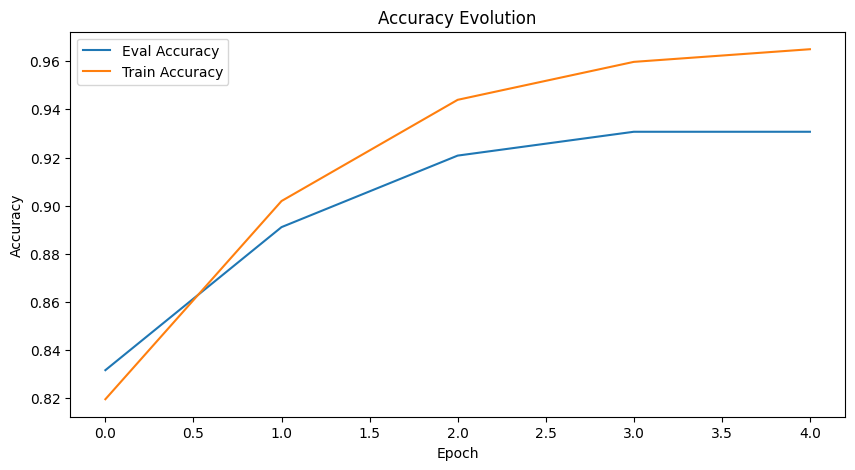

In [8]:
# Plot the train and test accuracy evolution
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history.eval_acc, label='Eval Accuracy')
plt.plot(accuracy_history.train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.show()

In [9]:

# After training, evaluate the model on the test set and compute the confusion matrix
predictions, labels, _ = trainer.predict(tokenized_test_data)
predictions = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(labels, predictions, labels=list(label2id.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))

  0%|          | 0/18 [00:00<?, ?it/s]

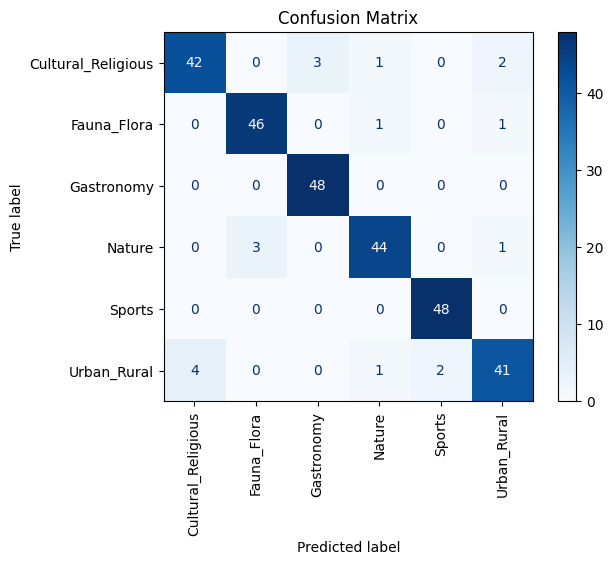

In [10]:

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [11]:
acc = accuracy_score(labels, predictions)
f1 = f1_score(labels, predictions, average='macro')
precision = precision_score(labels, predictions, average='macro')
recall = recall_score(labels, predictions, average='macro')
report = classification_report(labels, predictions, output_dict=True)

print(f"F1: {f1}")
print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"-------- Report --------")
print("Class\tPrecission\tRecall")
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = []
class_accuracy = []
for old_key, new_key in id2label.items():
    classes.append(new_key)
    class_accuracy.append(str(round(cm.diagonal()[old_key]*100, 2)))
print('\t'.join(classes))
print('\t'.join(class_accuracy))
# print(cm.diagonal())

F1: 0.9332326092561489
Accuracy: 0.9340277777777778
Precision: 0.9333794638217091
Recall: 0.9340277777777778
-------- Report --------
Class	Precission	Recall
Cultural_Religious	Fauna_Flora	Gastronomy	Nature	Sports	Urban_Rural
87.5	95.83	100.0	91.67	100.0	85.42
